In [7]:
import numpy as np 
import random
import math 
from statistics import mean
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import base64
import pandas as pd
from IPython.display import HTML
def create_download_link( df, title = "Download CSV file", filename = "data.csv"):
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)
prices=pd.read_csv("PricesFile1.csv")
df_wti=prices[prices.priceindex=='WTI NYMEX LIGHT SWEET']
df_wti=df_wti[pd.to_datetime(df_wti.pricedate) < pd.to_datetime(df_wti.delivdate)]
df_wti.rename(columns={'priceindex':'volatilityindex','pricedate': 'volatilitydate', 'delivdate': 'begtime'},inplace=True)

In [11]:
wti_mstr=pd.read_csv('master_wti_complete.csv')
wti_mstr.head()


,priceindex,pricedate,delivdate,price,key,duration,duration_months,volatilityindex,strikeprice,volatility,pricedate_r,maturity,bidrate,number,MorY,months
0,WTI NYMEX LIGHT SWEET,3/2/2020,4/1/2020,46.749,"2020-03-02,2020-04-01",30 days 00:00:00.000000000,1,V_WTI NYMEX LIGHT SWEET,25.0,0.933,3/2/2020,1M,1.110001,1,M,1
1,WTI NYMEX LIGHT SWEET,3/2/2020,4/1/2020,46.749,"2020-03-02,2020-04-01",30 days 00:00:00.000000000,1,V_WTI NYMEX LIGHT SWEET,25.5,0.913,3/2/2020,1M,1.110001,1,M,1
2,WTI NYMEX LIGHT SWEET,3/2/2020,4/1/2020,46.749,"2020-03-02,2020-04-01",30 days 00:00:00.000000000,1,V_WTI NYMEX LIGHT SWEET,26.0,0.893,3/2/2020,1M,1.110001,1,M,1
3,WTI NYMEX LIGHT SWEET,3/2/2020,4/1/2020,46.749,"2020-03-02,2020-04-01",30 days 00:00:00.000000000,1,V_WTI NYMEX LIGHT SWEET,26.5,0.874,3/2/2020,1M,1.110001,1,M,1
4,WTI NYMEX LIGHT SWEET,3/2/2020,4/1/2020,46.749,"2020-03-02,2020-04-01",30 days 00:00:00.000000000,1,V_WTI NYMEX LIGHT SWEET,27.0,0.855,3/2/2020,1M,1.110001,1,M,1


In [12]:
def OU_path(a,b,sigma,init,T):
    dt = .1  # Time step.
    T =  T # Total time.
    tau = .5
    sqrtdt = np.sqrt(dt)
    sigma_bis = sigma#* np.sqrt(2. / tau)
    n = int(T / dt)  # Number of time steps.
    x = np.zeros(n)
    t = np.linspace(0., T, n)  # Vector of times.
    x[0]=init
    for i in range(n - 1):
        x[i + 1] = x[i] +  a*(b - x[i])*dt + sigma_bis*sqrtdt*np.random.randn()
    return x

def OU_path2(a,b,sigma,init):
    delta = .25 # Time step.
    T = 32.  # Total time.
    n = int(T / delta)  # Number of time steps.
    x = np.zeros(n)
    sqrtdt = np.sqrt(delta)
    t = np.linspace(0., T, n)  # Vector of times.
    x[0]=init    # initial value
    for i in range(n - 1):
        q= b*(1 - math.exp(-a*delta) )
        r=sigma*math.sqrt((1- math.exp(-2*a*delta)/2*a))*np.random.randn()                         
        x[i + 1] = x[i]*math.exp(-a*delta) + q + r
    return x

## providing the parameters for a fixed initial date where we take into account futures price for all the dates.
## give just the 'price' coloumn
def a_b(x,delta):
    Sx = sum(x)-df_wti_1.price.iloc[len(x)-1]
    Sy=sum(x)-x.iloc[0]
    Sxx= sum((x)**2)-(x.iloc[len(x)-1])**2
    Syy = sum((x)**2)-(x.iloc[0])**2
    Sxy=0
    for i in range(len(x)-1):
        Sxy = Sxy+ x.iloc[i]*x.iloc[i+1]
    no=len(x)
    b= (Sy*Sxx-Sx*Sxy)/(no*(Sxx-Sxy) - (Sx**2 - Sx*Sy))
    a= -1*math.log((Sxy-b*Sx-b*Sy+no*b**2 )/(Sxx-2*b*Sx+no*b**2))/delta
    return a,b

In [85]:
## extract volatility and strike price to calculate call price using monte carlo simulation
wti1=wti_mstr[(wti_mstr.pricedate=='4/1/2020')&(wti_mstr.delivdate=='6/1/2021')]
df_wti_1=df_wti[df_wti.volatilitydate =='2020-04-01'] 
T = (wti1.duration_months.unique())
pr=df_wti_1.price
acumpayof=0
K=35
dt=.1
n = int(T/dt)
t=np.linspace(0.,T,n)
npaths=150
for i in range(npaths):
    x = OU_path(a_b(pr,1)[0],a_b(pr,1)[1], wti1.volatility[wti1.strikeprice==K] , min(df_wti_1.price),T)
#    plt.plot(t,x,lw=2)
    acumpayof=acumpayof+ max((x[-1] - K),0 )

call_p = (acumpayof/npaths)*math.exp(-1*(T/1200-10/360)*wti1.bidrate[wti1.strikeprice==K]*(T/12-10/360))
#wti1
call_p


0.012135817504487919

4.758107088037737

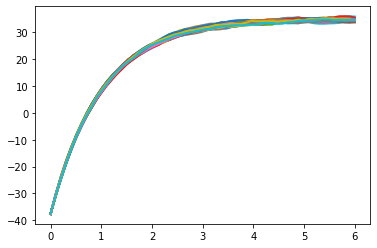

In [15]:
## extract volatility and strike price to calculate call price using monte carlo simulation
wti1=wti_mstr[(wti_mstr.pricedate=='4/20/2020')&(wti_mstr.delivdate=='11/1/2020')]
df_wti_1=df_wti[df_wti.volatilitydate =='2020-04-20'] 
T = (wti1.duration_months.unique())
pr=df_wti_1.price
acumpayof=0
K=30
dt=.1
n = int(T/dt)
t=np.linspace(0.,T,n)
npaths=50
for i in range(npaths):
    x = OU_path(a_b(pr,1)[0],a_b(pr,1)[1], wti1.volatility[wti1.strikeprice==K] , min(df_wti_1.price),T)
    plt.plot(t,x,lw=2)
    acumpayof=acumpayof+ max((x[-1] - K),0 )

call_p = (acumpayof/npaths)*math.exp(-1*(T/1200)*wti1.bidrate[wti1.strikeprice==K]*(T/12))
call_p

In [16]:
## extract volatility and strike price to calculate call price using monte carlo simulation
df_wti_1=df_wti[df_wti.volatilitydate =='2020-03-02']
wti1=wti_mstr[(wti_mstr.pricedate=='3/2/2020')&(wti_mstr.delivdate=='11/1/2020')]
T = (wti1.duration_months.unique())
pr=df_wti_1.price
acumpayof=0
K=30
dt=.1
n = int(T/dt)
t=np.linspace(0.,T,n)
npaths=50
for i in range(npaths):
    x = OU_path(a_b(pr,1)[0],a_b(pr,1)[1], wti1.volatility[wti1.strikeprice==K] , min(df_wti_1.price),T)
    acumpayof=acumpayof+ max((x[-1] - K),0 )

call_p = (acumpayof/npaths)*math.exp(-1*(T/1200)*wti1.bidrate[wti1.strikeprice==K]*(T/12))
call_p,T, wti1.price.mean()

(17.080895235424922, array([8]), 47.398999999999916)

In [17]:
## extract volatility and strike price to calculate call price using monte carlo simulation
df_wti_1=df_wti[df_wti.volatilitydate =='2020-04-15']
wti1=wti_mstr[(wti_mstr.pricedate=='4/15/2020')&(wti_mstr.delivdate=='11/1/2020')]
T = (wti1.duration_months.unique())
pr=df_wti_1.price
acumpayof=0
K=25
dt=.1
n = int(T/dt)
t=np.linspace(0.,T,n)
npaths=50
for i in range(npaths):
    x = OU_path(a_b(pr,1)[0],a_b(pr,1)[1], wti1.volatility[wti1.strikeprice==K] , min(df_wti_1.price),T)
    acumpayof=acumpayof+ max((x[-1] - K),0 )

call_p = (acumpayof/npaths)*math.exp(-1*(T/1200)*wti1.bidrate[wti1.strikeprice==K]*(T/12))
call_p

4.264811581370292